# ESSI - MVP - PUC-RIO - Bruno Bastos
Este notebook contém o código para treinamento e avaliação dos modelos de classificação do dataset Titanic.
Este projeto faz parte da última sprint do curso de enenharia de software da PUC-RIO.

# Importações

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib
from IPython.display import HTML
import warnings

warnings.filterwarnings('ignore')

# definindo constantes para controle de seed e test_size
SEED = 7
TEST_SIZE = 1 / 4

# ANOTAÇÕES SOBRE OS MELHORES RESULTADOS OBTIDOS
# RF PADRONIZADO: 0.8841463414634146 (SEED=10 e TEST_SIZE=1/4)
# SVM PADRONIZADO: 0.8475609756097561 (SEED=7 e TEST_SIZE=1/4)

MODELOS_SOLICITADOS = ['KNN', 'NB', 'CART', 'SVM']
USAR_APENAS_MODELOS_SOLICITADOS = True


# Carregar, explorar e tratar os dados

In [12]:
# Carregar o dataset
url = "https://raw.githubusercontent.com/BrunoBasstos/mvp-iv-notebook/main/src/titanic-dataset.csv"
original_ds = pd.read_csv(url)

# Explorando os dados

# Exibir as primeiras linhas
print("Primeiras linhas:")
display(original_ds.head())

# exibir dtypes, valores únicos e valores nulos
print("Tipos de dados, valores únicos e valores nulos:")
display(pd.concat([original_ds.dtypes, original_ds.nunique(), original_ds.isnull().sum()], axis=1,
                  keys=['dtypes', 'valores únicos', 'valores nulos']))

# valores únicos, em tese, podem ser menos relevantes para o modelo. Para fins de teste,
# vou desconsiderar as colunas PassengerId e Name (embora Name pareça ter informações relevantes, como o título da pessoa)
colunas_desconsiderar = ['PassengerId', 'Name']

# Tratar as idades nulas pode ajudar o modelo, vamos tentar alguma estratégia que calcule a média de idade mas mantendo segregado por sexo e classe
# criar um dicionário com a média de idade por sexo e classe
media_idade_por_sexo_classe = original_ds.groupby(['Sex', 'Pclass'])['Age'].mean()


# Função para preencher idades nulas
def preencher_idade(row):
    # Se a idade é nula
    if pd.isnull(row['Age']):
        # Retornar a média de idade para a combinação de sexo e classe do passageiro
        return media_idade_por_sexo_classe[row['Sex'], row['Pclass']]
    else:
        # Se a idade não é nula, retornar a idade
        return row['Age']


# substituindo os valores nulos de idade no dataset original
original_ds['Age'] = original_ds.apply(preencher_idade, axis=1)

# Cabin tem muitos valores nulos, mas pode ser relevante para o modelo considerando que a cabine indica a posição do passageiro no navio
# @TODO: investigar uma transformação que busque agrupar os passageiros por setores do navio usando a informação de cabin
# vamos deixar cabin fora do treinamento por ora
colunas_desconsiderar.append('Cabin')


# Selecionar colunas consideradas relevantes para o modelo (todas as colunas, exceto as marcadas como "desconsiderar")
colunas = original_ds.columns.difference(colunas_desconsiderar)
data = original_ds[colunas]

Primeiras linhas:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Tipos de dados, valores únicos e valores nulos:


,dtypes,valores únicos,valores nulos
PassengerId,int64,1309,0
Survived,int64,2,0
Pclass,int64,3,0
Name,object,1307,0
Sex,object,2,0
Age,float64,98,263
SibSp,int64,7,0
Parch,int64,8,0
Ticket,object,929,0
Fare,float64,281,1


# Separação os dados

In [13]:
# Divisão dos dados em treino e teste
X = data.drop('Survived', axis=1)
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

# Separando os dados em numéricos e categóricos (deixar Cabin fora pois terá tratamento separado
num_features = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp']
cat_features = ['Sex', 'Embarked']

# Definição dos modelos e pré-processadores

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# transformers.py

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

# Configurações dos modelos
modelos = {
    'KNN': KNeighborsClassifier(),
    'NB': GaussianNB(),
    'CART': DecisionTreeClassifier(random_state=SEED),
    'SVM': SVC(random_state=SEED, probability=True),
    # adicionando mais modelos por curiosidade (manter apenas os modelos solicitados)
    'RF': RandomForestClassifier(),
    'LR': LogisticRegression(),
}

parametros = {
    'KNN': {'classifier__n_neighbors': [3, 5, 7, 9]},
    'NB': {'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]},
    'CART': {'classifier__max_depth': [3, 5, 7, None], 'classifier__min_samples_split': [2, 3, 5]},
    'SVM': {'classifier__C': [0.1, 1, 10, 100], 'classifier__gamma': ['scale', 'auto']},
    # adicionando mais modelos por curiosidade (manter apenas os modelos solicitados)
    'RF': {'classifier__n_estimators': [100, 200, 300], 'classifier__max_depth': [3, 5, 7, None],
           'classifier__min_samples_split': [2, 3, 5], 'classifier__n_jobs': [-1]},
    'LR': {'classifier__C': [0.1, 1, 10, 100], 'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
}

# Preparação de Pré-processadores
preprocessors = {
    'original': ColumnTransformer(transformers=[
        ('num', SimpleImputer(strategy='median'), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]),
    'padronizado': ColumnTransformer(transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]),
    'normalizado': ColumnTransformer(transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler())]), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])
}

# Treinamento e avaliação dos modelos

original - KNN: Melhor Score = 0.7247487827618357
original - NB: Melhor Score = 0.856267481611934
original - CART: Melhor Score = 0.8603491142649954
original - SVM: Melhor Score = 0.8399616699471668
padronizado - KNN: Melhor Score = 0.8542318450222728
padronizado - NB: Melhor Score = 0.8593287061017302
padronizado - CART: Melhor Score = 0.8603491142649954
padronizado - SVM: Melhor Score = 0.8715580648503056
normalizado - KNN: Melhor Score = 0.8623951103283953
normalizado - NB: Melhor Score = 0.8583082979384647
normalizado - CART: Melhor Score = 0.8603491142649954
normalizado - SVM: Melhor Score = 0.8664715632445873


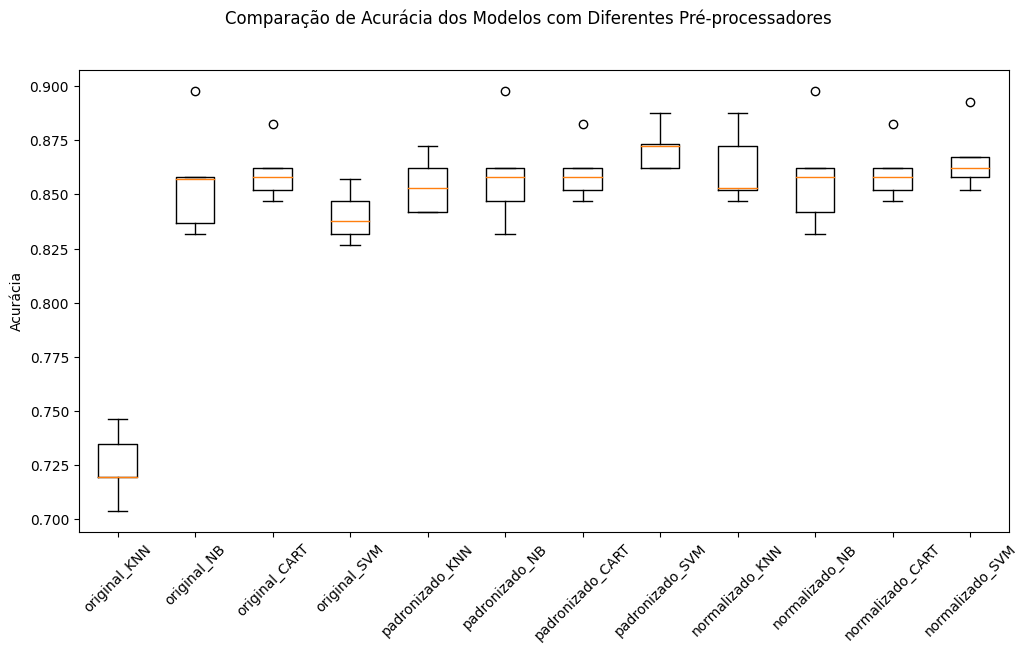

In [16]:
from matplotlib import pyplot as plt

# Avaliação dos Modelos com Diferentes Pré-processamentos
# Como o dataset é pequeno, optei por fazer o processo automaticamente usando um loop duplo e fazendo a validação cruzada de cada modelo

# Criação do objeto kfold para validação cruzada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# lista para armazenar os melhores resultados
melhores_resultados = {}

# Dicionário para armazenar os resultados de validação cruzada de cada modelo
resultados_cv = {}

# Iterando sobre cada pré-processador e modelo para treinamento e avaliação
for preproc_nome, preproc in preprocessors.items():
    for nome_modelo, modelo in modelos.items():
        # Se a flag USAR_APENAS_MODELOS_SOLICITADOS for verdadeira, pula os modelos não solicitados (facilitar a execução pelos professores)
        if USAR_APENAS_MODELOS_SOLICITADOS and nome_modelo not in MODELOS_SOLICITADOS:
            continue

        # Criando um pipeline com o pré-processador e o modelo atual
        pipeline = Pipeline([('preprocessor', preproc), ('classifier', modelo)])

        # Verifica se há parâmetros definidos para o modelo atual
        if parametros[nome_modelo]:
            # Cria um objeto GridSearchCV para otimização de hiperparâmetros
            grid_search = GridSearchCV(pipeline, parametros[nome_modelo], cv=kfold, scoring='accuracy')
            # Treina o modelo com o GridSearchCV
            grid_search.fit(X_train, y_train)
            # Salva o melhor modelo encontrado para incluir na lista de melhores resultados
            melhor_modelo = grid_search.best_estimator_
            # Salva o melhor score obtido para incluir na lista de melhores resultados
            score = grid_search.best_score_
        else:
            # Se não há parâmetros para ajustar, usa o modelo como está
            melhor_modelo = pipeline
            melhor_modelo.fit(X_train, y_train)  # Treinando o modelo
            # Calculando a média de acurácia com validação cruzada
            score = cross_val_score(melhor_modelo, X_train, y_train, cv=kfold, scoring='accuracy').mean()

        # Exibindo os resultados
        print(f"{preproc_nome} - {nome_modelo}: Melhor Score = {score}")
        # Armazenando o melhor modelo e o score correspondente no dicionário
        melhores_resultados[f"{preproc_nome}_{nome_modelo}"] = (melhor_modelo, score)
        # Armazenando os resultados do melhor modelo da validação cruzada
        resultados_cv[f"{preproc_nome}_{nome_modelo}"] = cross_val_score(melhor_modelo, X_train, y_train, cv=kfold,
                                                                         scoring='accuracy')

# Criando o boxplot para comparação dos resultados
fig = plt.figure(figsize=(12, 6))
fig.suptitle('Comparação de Acurácia dos Modelos com Diferentes Pré-processadores')
ax = fig.add_subplot(111)
plt.boxplot(resultados_cv.values())
ax.set_xticklabels(resultados_cv.keys())
plt.xticks(rotation=45)
plt.ylabel('Acurácia')
plt.show()



# Escolhe, treina e salva o melhor modelo

In [17]:
# Escolher o Melhor Modelo Geral
melhor_modelo_geral = max(melhores_resultados.items(), key=lambda x: x[1][1])

# Treinar o melhor modelo geral com todo o conjunto de treinamento
melhor_modelo_geral[1][0].fit(X_train, y_train)

# Avaliar a acurácia do melhor modelo no conjunto de teste
y_pred = melhor_modelo_geral[1][0].predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do melhor modelo no conjunto de teste: {accuracy}")

# Exportar o melhor modelo
joblib.dump(melhor_modelo_geral[1][0], f'_titanic.pkl')
print(f"Melhor modelo geral ({melhor_modelo_geral[0]}) exportado como '_titanic.pkl'")

# Exportar o dataset de teste para uso nos testes automatizados
test_dataset = pd.concat([X_test, y_test], axis=1)
test_dataset.to_csv('_test_dataset.csv', index=False)


Acurácia do melhor modelo no conjunto de teste: 0.850609756097561
Melhor modelo geral (padronizado_SVM) exportado como '_titanic.pkl'


# Exemplo de uso do modelo

In [18]:
# Função para exibir a predição com cores
def exibir_predicao(predicao, numero_teste):
    cor = "green" if predicao[0] == 1 else "red"
    status = "sobreviveu" if predicao[0] == 1 else "não sobreviveu"
    return HTML(f"<b>Predição {numero_teste}:</b> Passageiro <span style='color: {cor};'>{status}</span>")


# Carregar o modelo
modelo = joblib.load('_titanic.pkl')

# Dados de entrada
#Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
entrada1 = {
    'Pclass': 3,
    'Name': 'Mr. Owen Harris Braund',
    'Sex': 'male',
    'Age': 22,
    'SibSp': 1,
    'Parch': 0,
    'Ticket': 'A/5 21171',
    'Fare': 7.25,
    'Cabin': '',
    'Embarked': 'S'
}

entrada1 = pd.DataFrame(entrada1, index=[0])
predicao1 = modelo.predict(entrada1)
display(exibir_predicao(predicao1, 1))
# Teste 2

# Dados de entrada

entrada2 = {
    'Pclass': 1,
    'Name': 'Mrs. John Bradley (Florence Briggs Thayer) Cumings',
    'Sex': 'female',
    'Age': 38,
    'SibSp': 1,
    'Parch': 0,
    'Ticket': 'PC 17599',
    'Fare': 71.2833,
    'Cabin': 'C85',
    'Embarked': 'C'
}

# Preparar e exibir a segunda predição
entrada2 = pd.DataFrame(entrada2, index=[0])
predicao2 = modelo.predict(entrada2)
display(exibir_predicao(predicao2, 2))